In [1]:
import os
import glob
import time

import GPRutils
import DESutils
import vK2KGPR

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

exps = DESutils.findExpNums()
gband = DESutils.bandDict["g"]
rband = DESutils.bandDict["r"]
iband = DESutils.bandDict["i"]
zband = DESutils.bandDict["z"]

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
def printXi(dC, params, curl):
    t0 = time.time()
    GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=curl)
    GP.fit(params)
    GP.predict(dC.Xvalid)
    
    
    GPRutils.printParams(dC.params)
    xi0, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid)
    xi0err = np.sqrt(Xerr**2 + Yerr**2)
    print(f"xi0: {xi0:.3f} ± {xi0err:.3f} mas^2")
    
    xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
    xiferr = np.sqrt(Xerr**2 + Yerr**2)
    print(f"xif: {xif:.3f} ± {xiferr:.3f} mas^2")
    
    red = xi0/xif
    rederr = np.sqrt(((xi0err/xi0)**2 + (xiferr/xif)**2) * red**2)
    print(f"Reduction: {red:.3f} ± {rederr:.3f}")
    tf = time.time()
    print(f"{tf-t0:.3f} sec")
    print()
    return xi0, xi0err, xif, xiferr, red, rederr

In [3]:
expNum = zband[0]

In [4]:
dC = GPRutils.loadFITS(f"/home/fortino/GPRSolutions/simple/GPR.{expNum}.?RC.fits")
dC.summarize(noplots=True, xionly=False)

fitCorrParams = dC.fitCorrParams.copy()
finalParams = dC.params.copy()

Exposure: 348819
Band: z
Kernel Parameters from 2d Correlation Fitting
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
109.1565559    1.5349095      -0.0061141     0.0890528      -0.0355237     

Kernel Parameters from GPR Optimization
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
220.7504306    0.5817545      -0.0084507     0.0122671      -0.030748      

Jackknifed xi+ (Inter-set pairs excluded)
xi0: 83.083 ± 1.693 mas^2
xif: 5.641 ± 0.486 mas^2
Reduction: 14.729



In [5]:
xi0_0, xi0err_0, xif_0, xiferr_0, red_0, rederr_0 = printXi(dC, fitCorrParams, curl=True)
xi0_f, xi0err_f, xif_f, xiferr_f, red_f, rederr_f = printXi(dC, finalParams, curl=True)

109.1565559    1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.289 ± 1.523 mas^2
Reduction: 6.667 ± 0.891
151.746 sec

220.7504306    0.5817545      -0.0084507     0.0122671      -0.030748      
xi0: 81.926 ± 4.118 mas^2
xif: 7.377 ± 1.337 mas^2
Reduction: 11.105 ± 2.089
151.651 sec



In [6]:
N = 24
param_xi0_list = []
param_xi0_err_list = []
param_xif_list = []
param_xif_err_list = []
param_red_list = []
param_red_err_list = []
for i in range(5):
    p_i = sorted([fitCorrParams[i], finalParams[i]])
    p_i_list = np.linspace(0.75*p_i[0], 1.25*p_i[1], N)
    param_list = np.array([fitCorrParams]*N)
    param_list[:, i] = p_i_list
    
    xi0_list = []
    xi0_err_list = []
    xif_list = []
    xif_err_list = []
    red_list = []
    red_err_list = []
    for params in param_list:
        xi0, xi0err, xif, xiferr, red, rederr = printXi(dC, params, curl=True)
        
        xi0_list.append(xi0)
        xi0_err_list.append(xi0err)
        xif_list.append(xif)
        xif_err_list.append(xiferr)
        red_list.append(red)
        red_err_list.append(rederr)
        
    param_xi0_list.append(xi0_list)
    param_xi0_err_list.append(xi0_err_list)
    param_xif_list.append(xif_list)
    param_xif_err_list.append(xif_err_list)
    param_red_list.append(red_list)
    param_red_err_list.append(red_err_list)

81.8674169     1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.796 ± 1.533 mas^2
Reduction: 6.402 ± 0.832
153.527 sec

90.30527       1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.606 ± 1.529 mas^2
Reduction: 6.499 ± 0.853
156.787 sec

98.7431231     1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.448 ± 1.526 mas^2
Reduction: 6.581 ± 0.872
156.546 sec

107.1809762    1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.317 ± 1.523 mas^2
Reduction: 6.652 ± 0.888
158.656 sec

115.6188293    1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.205 ± 1.521 mas^2
Reduction: 6.712 ± 0.902
157.919 sec

124.0566824    1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.111 ± 1.520 mas^2
Reduction: 6.765 ± 0.914
153.675 sec

132.

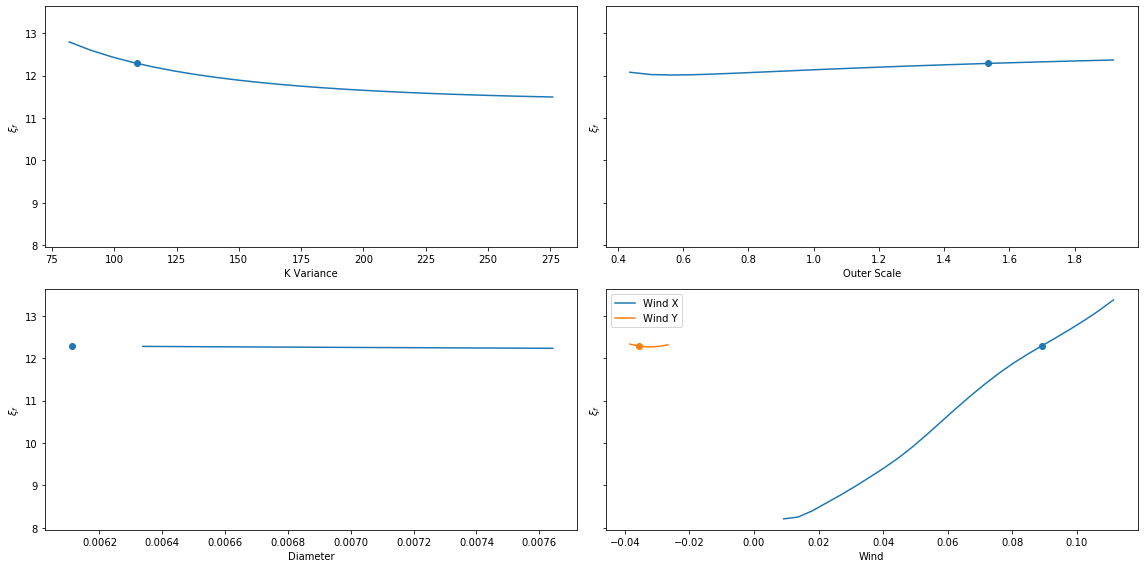

In [37]:
finalxif = 12.289
p_names = ["K Variance", "Outer Scale", "Diameter", "Wind X", "Wind Y"]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(16, 8))

i = 0
p_i = sorted([fitCorrParams[i], finalParams[i]])
p_i_list = np.linspace(0.75*p_i[0], 1.25*p_i[1], N)
axes[0, 0].plot(p_i_list, param_xif_list[i])
axes[0, 0].scatter(fitCorrParams[i], 12.289)
# axes[0, 0].scatter(finalParams[i], 7.377, label="final Parameter")
axes[0, 0].set_xlabel(p_names[i])
axes[0, 0].set_ylabel(r"$\xi_f$")


i = 1
p_i = sorted([fitCorrParams[i], finalParams[i]])
p_i_list = np.linspace(0.75*p_i[0], 1.25*p_i[1], N)
axes[0, 1].plot(p_i_list, param_xif_list[i])
axes[0, 1].scatter(fitCorrParams[i], 12.289)
# axes[0, 1].scatter(finalParams[i], 7.377, label="final Parameter")
axes[0, 1].set_xlabel(p_names[i])
axes[0, 1].set_ylabel(r"$\xi_f$")

i = 2
p_i = np.abs(sorted([fitCorrParams[i], finalParams[i]]))
p_i_list = np.linspace(0.75*p_i[0], 1.25*p_i[1], N)
axes[1, 0].plot(p_i_list, param_xif_list[i])
axes[1, 0].scatter(np.abs(fitCorrParams[i]), 12.289)
# axes[1, 0].scatter(finalParams[i], 7.377, label="final Parameter")
axes[1, 0].set_xlabel(p_names[i])
axes[1, 0].set_ylabel(r"$\xi_f$")

i = 3
p_i = sorted([fitCorrParams[i], finalParams[i]])
p_i_list = np.linspace(0.75*p_i[0], 1.25*p_i[1], N)
axes[1, 1].plot(p_i_list, param_xif_list[i], label=p_names[i])
axes[1, 1].scatter(fitCorrParams[i], 12.289)
# axes[1, 1].scatter(finalParams[i], 7.377, label="final Parameter")

i = 4
p_i = sorted([fitCorrParams[i], finalParams[i]])
p_i_list = np.linspace(0.75*p_i[0], 1.25*p_i[1], N)
axes[1, 1].plot(p_i_list, param_xif_list[i], label=p_names[i])
axes[1, 1].scatter(fitCorrParams[i], 12.289)
# axes[1, 1].scatter(finalParams[i], 7.377, label="final Parameter")

axes[1, 1].set_xlabel("Wind")
axes[1, 1].set_ylabel(r"$\xi_f$")

axes[1, 1].legend()

plt.tight_layout()
plt.show()